<a href="https://colab.research.google.com/github/Nico5144/mnist-ml-project/blob/main/notebooks/4_cnn_and_saliency_ver0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import backend as K

# 1. Load & preprocess MNIST

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# 2. Define simple CNN

model = Sequential([
    Reshape((28, 28, 1), input_shape=(28, 28)),
    Conv2D(32, 3, activation='relu', name='conv1'),
    MaxPooling2D(name='pool1'),
    Conv2D(64, 3, activation='relu', name='conv2'),
    MaxPooling2D(name='pool2'),
    Flatten(),
    Dense(128, activation='relu', name='dense1'),
    Dense(10, activation='softmax', name='output')
])


# compiles model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [15]:
# 3. Train CNN

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    verbose=2
)


# # Run after training/compile to run small predict of graph for grad-CAM

# _ = model.predict(X_train[:1])    # runs one batch → builds the internal graph

# # Now you can grab model.input/output and layer.output
# last_conv = model.get_layer('conv2')
# from tensorflow.keras.models import Model
# grad_model = Model(
#     inputs= model.input,                         # singular .input
#     outputs=[last_conv.output, model.output]
# )



Epoch 1/20
422/422 - 39s - 92ms/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9915 - val_loss: 0.0359
Epoch 2/20
422/422 - 37s - 88ms/step - accuracy: 0.9976 - loss: 0.0069 - val_accuracy: 0.9902 - val_loss: 0.0460
Epoch 3/20
422/422 - 35s - 84ms/step - accuracy: 0.9981 - loss: 0.0059 - val_accuracy: 0.9892 - val_loss: 0.0459
Epoch 4/20
422/422 - 41s - 97ms/step - accuracy: 0.9978 - loss: 0.0063 - val_accuracy: 0.9900 - val_loss: 0.0507
Epoch 5/20
422/422 - 40s - 95ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9918 - val_loss: 0.0428
Epoch 6/20
422/422 - 42s - 99ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9897 - val_loss: 0.0547
Epoch 7/20
422/422 - 41s - 97ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9918 - val_loss: 0.0464
Epoch 8/20
422/422 - 41s - 97ms/step - accuracy: 0.9982 - loss: 0.0050 - val_accuracy: 0.9907 - val_loss: 0.0517
Epoch 9/20
422/422 - 40s - 94ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9908 - 

In [10]:
# # 3.5 Plots to observe efficacy of training

# import matplotlib.pyplot as plt

# # Loss curves

# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='val')
# plt.title('Loss Curve')
# plt.legend()

# # Accuracy curves

# plt.subplot(1,2,2)
# plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_accuracy'], label='val')
# plt.title('Accuracy Curve')
# plt.legend()
# plt.show()


# #sanity check to see if exists

# print("Model input:", model.input)
# print("Model output:", model.output)
# print("Conv2 output:", last_conv.output)




# # Run after training/compile to run small predict of graph for grad-CAM


# model.build(input_shape=(None, 28, 28))



# _ = model.predict(X_train[:1])    # runs one batch → builds the internal graph

# # Now you can grab model.input/output and layer.output
# last_conv = model.get_layer('conv2')
# from tensorflow.keras.models import Model
# grad_model = Model(
#     inputs= model.input,                         # singular .input
#     outputs=[last_conv.output, model.output]
# )

pass


In [16]:
# 4. Evaluate on test set

test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"CNN Test Accuracy: {test_acc:.4f}")



CNN Test Accuracy: 0.9915


In [17]:
# 5. Build grad‑CAM model

from tensorflow.keras.models import Model

last_conv_layer = model.get_layer('conv2')

grad_model = Model(
    inputs = model.inputs,                    # list of input tensors
    outputs = [ last_conv_layer.output,       # feature maps from conv2
                model.outputs[0] ]            # the softmax output tensor
)

def compute_gradcam(img, class_idx):
    img_tensor = np.expand_dims(img, axis=0)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    heatmap = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i in range(conv_outputs.shape[-1]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap



313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


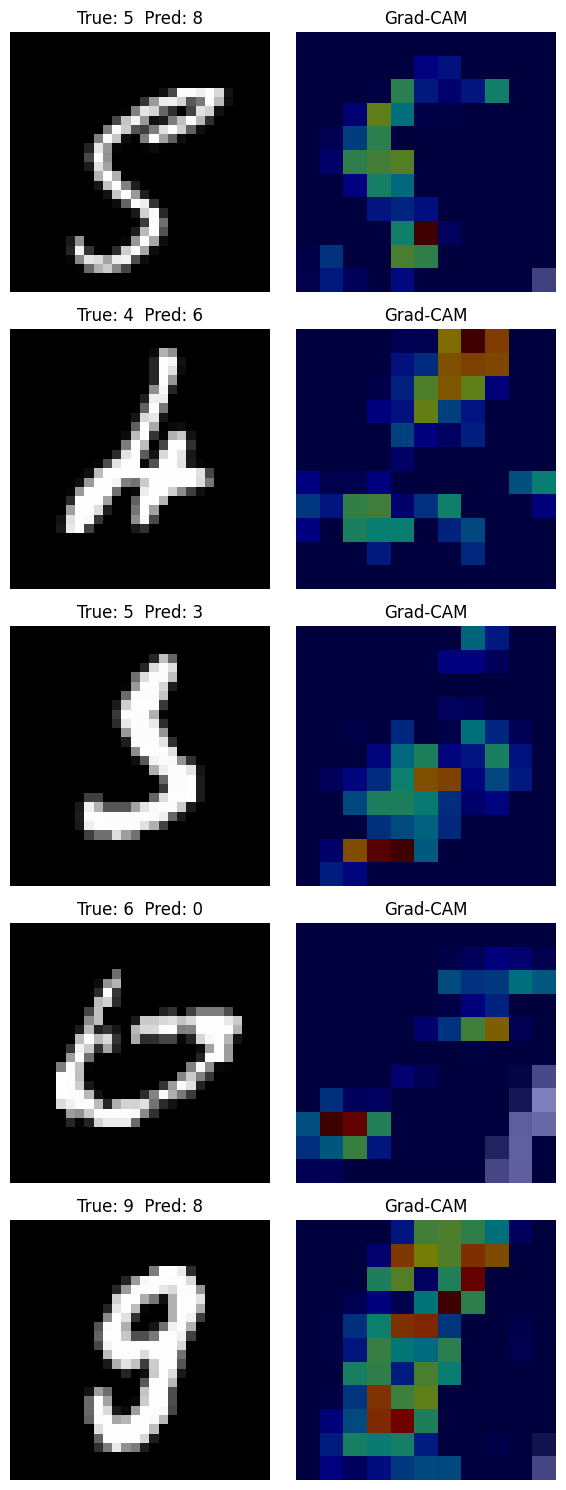

In [18]:
# 6. Visualize misclassifications with grad‑CAM

preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
mis_idxs = np.where(y_pred != y_test)[0][:5]

fig, axs = plt.subplots(5, 2, figsize=(6, 15))
for i, idx in enumerate(mis_idxs):
    img = X_test[idx]

    # Original image

    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title(f"True: {y_test[idx]}  Pred: {y_pred[idx]}")
    axs[i, 0].axis('off')

    # Grad‑CAM overlay

    heatmap = compute_gradcam(img, y_pred[idx])
    axs[i, 1].imshow(img, cmap='gray')
    axs[i, 1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[i, 1].set_title("Grad‑CAM")
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()


In [20]:
# After model training

model.save('mnist_cnn.keras')     # saves architecture + weights
